# Load an edgelist and build the network


In [1]:
import os, sys
import json
import pickle
from sqlitedict import SqliteDict
import json
import numpy as np
import graph_tool.all as gt
import matplotlib.pyplot as plt

import utils_network
import utils_gt
import utils_network_metrics

%load_ext autoreload
%autoreload 2

# Load datasets

In [2]:
FNAME_data = "KNOT_networks.sqlite"
dict_data = SqliteDict(FNAME_data)



In [3]:
## load a session
i = 2
datai= dict_data[i]


In [4]:
## get the list of nodes
list_nodes = [{"index":i, "page_title":h.strip()} for i,h in enumerate(datai["nodes"])]
list_nodes[:10]

[{'index': 0, 'page_title': 'Restrictive lung disease'},
 {'index': 1, 'page_title': 'Emphysema'},
 {'index': 2, 'page_title': 'Obstructive lung disease'},
 {'index': 3, 'page_title': 'Bronchiectasis'},
 {'index': 4, 'page_title': 'Pneumonia'},
 {'index': 5, 'page_title': 'Pulmonary function testing'},
 {'index': 6, 'page_title': 'Arterial blood gas test'},
 {'index': 7, 'page_title': 'Metabolic acidosis'},
 {'index': 8, 'page_title': 'Respiratory acidosis'},
 {'index': 9, 'page_title': 'Respiratory alkalosis'}]

In [5]:
## get the list of edges
list_edges = []
Aij = datai["adj"]
N = len(list_nodes)
for i1 in range(N):
    for i2 in range(N):
        if i1<i2:
            if Aij[i1,i2] == 1:
                list_edges+=[(i1,i2)]
list_edges[:10]


[(0, 2),
 (0, 5),
 (0, 109),
 (1, 11),
 (1, 12),
 (2, 3),
 (2, 5),
 (2, 12),
 (2, 15),
 (3, 4)]

In [6]:
## make graph
g_gt = utils_gt.make_graph_links(list_nodes, list_edges,directed=False)
print(g_gt)

<Graph object, undirected, with 125 vertices and 170 edges, 2 internal vertex properties, at 0x7ff020fe9590>


### Community detection

State summary:
l: 0, N: 125, B: 4
l: 1, N: 4, B: 2
l: 2, N: 2, B: 1
l: 3, N: 1, B: 1


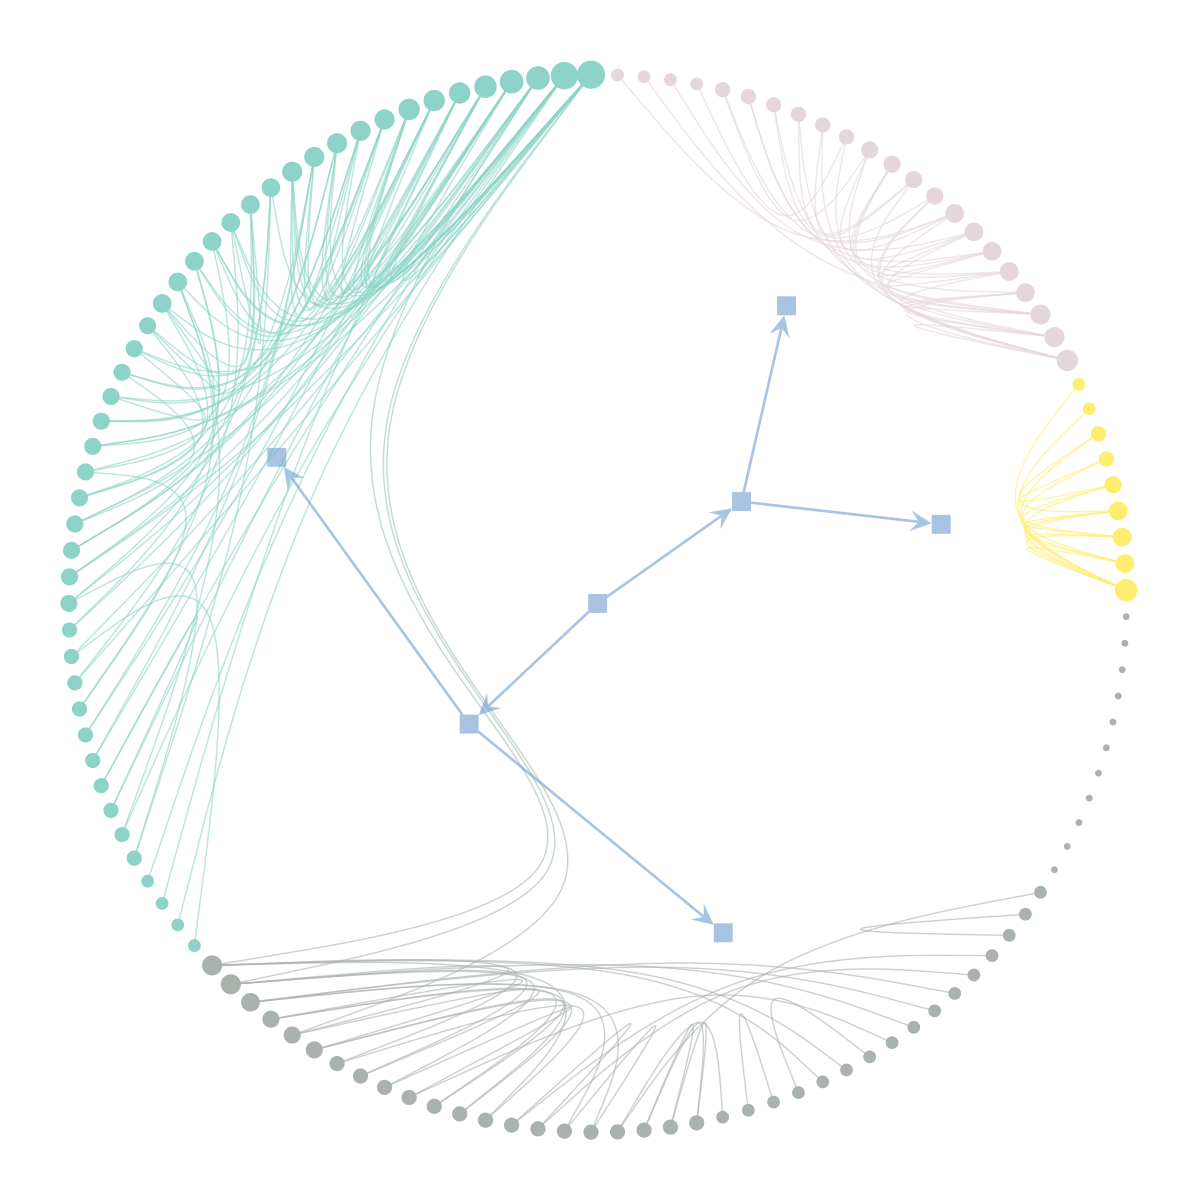

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7ff020fe9590, at 0x7ff0211c5e90>,
 <Graph object, directed, with 132 vertices and 131 edges, at 0x7ff020e4c750>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7ff020e4c750, at 0x7ff020766050>)

In [7]:
state = gt.minimize_nested_blockmodel_dl(g_gt)
# for i in range(100):
#     ret = state.multiflip_mcmc_sweep(niter=10, beta=np.inf)
print("State summary:")
state.print_summary()
state.draw()

In [8]:
mdl = state.entropy()
mdlr=gt.minimize_nested_blockmodel_dl(g_gt,multilevel_mcmc_args=dict(B_min=1, B_max=1)).entropy()
print("MDL: ",mdl )
print("MDL-randomized: ",mdlr)
print("Delta-MDL :", mdlr-mdl)

MDL:  812.4422124588144
MDL-randomized:  833.3797144611613
Delta-MDL : 20.937502002346832


In [9]:
## filtration metric
dict_result = utils_network_metrics.filtration_metric_mdl(g_gt,s=10,n_mcmc=0)


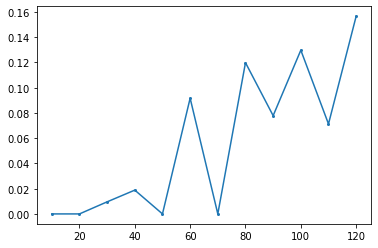

In [10]:
list_n=np.array(dict_result["nodes"])
list_e=np.array(dict_result["edges"])
list_mdl=np.array(dict_result["mdl"])
list_mdlr=np.array(dict_result["mdl_random"])
list_time=np.array(dict_result["time"])

delta_mdl_norm = (list_mdlr-list_mdl)/list_n
#     print(delta_mdl_norm)
plt.plot(list_n,delta_mdl_norm,marker='o',ms=2)